In [2]:
from stable_baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
#from google.colab import drive
import gym.wrappers
#drive.mount('/content/gdrive',force_remount=True)

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


(210, 160, 3)


/home/matheus/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


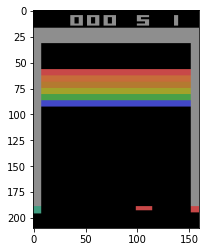

In [3]:
env = make_atari("BreakoutNoFrameskip-v4")

obs = env.reset()
print(obs.shape)
plt.imshow(obs)

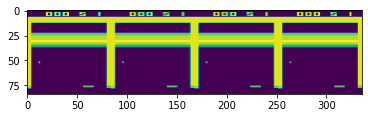

In [8]:
env = make_atari("BreakoutNoFrameskip-v4")
env = wrap_deepmind(env,frame_stack=True, scale = True)
obs = np.array(env.reset())
plt.imshow(obs.transpose([0,2,1]).reshape([env.observation_space.shape[0],-1]))

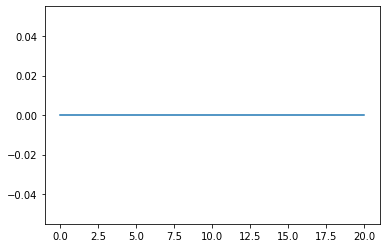

In [13]:
env.reset()
rewards = []
while True:
    obs,rew,done,info = env.step(env.action_space.sample())
    rewards.append(rew)
    if done:
        break
plt.plot(rewards)

In [14]:
num_actions = 4

def create_q_model():
    inputs = layers.Input(shape=(84,84,4,))
    layer1 = layers.Conv2D(32, 8, strides = 4, activation = "relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides = 2, activation = "relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides = 1, activation = "relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation = "relu")(layer4)
    action = layers.Dense(num_actions, activation = "linear")(layer5)
    return keras.Model(inputs=inputs,outputs=action)

model = create_q_model()
model_target = create_q_model()

2022-06-16 21:44:14.698083: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/matheus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-06-16 21:44:14.698147: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-16 21:44:14.698185: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mf): /proc/driver/nvidia/version does not exist
2022-06-16 21:44:14.741237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
gamma = 0.99  # Discount factor for past rewards

# Setting epsilon decay parameters
epsilon = 1.0  
epsilon_max_1 = 1.0 
epsilon_min_1 = 0.2  
epsilon_max_2 = epsilon_min_1  
epsilon_min_2 = 0.1
epsilon_max_3 = epsilon_min_2  
epsilon_min_3 = 0.02

epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)  
epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)  
epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)  

# Number of frames for exploration
epsilon_greedy_frames = 1000000.0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Maximum Replay Buffer volume
max_memory_length = 190000

# Size of batch taken from replay buffer
batch_size = 32  
max_steps_per_episode = 10000

# Train the model after 20 actions
update_after_actions = 20

# How often to update the target network
update_target_network = 10000

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Using huber loss for stability
loss_function = keras.losses.Huber()


In [27]:
from numba import jit,cuda

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []

episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

i = 1
while i < 1000:  # Run until solved
    i = i + 1
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        if frame_count < epsilon_greedy_frames:
            epsilon -= epsilon_interval_1 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_1)
        
        if frame_count > epsilon_greedy_frames and frame_count < 2 * epsilon_greedy_frames:
            epsilon -= epsilon_interval_2 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_2)
        
        if frame_count > 2 * epsilon_greedy_frames:
            epsilon -= epsilon_interval_3 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_3)
        

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every 20th frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {:.3f}, loss {:.5f}"
            print(template.format(running_reward, episode_count, frame_count, epsilon, loss))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 18:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

1/1 [==============================] - 0s 18ms/step
running reward: 0.13 at episode 312, frame count 10000, epsilon 0.992, loss 0.01611
1/1 [==============================] - 0s 17ms/step
running reward: 0.28 at episode 610, frame count 20000, epsilon 0.984, loss 0.00384
1/1 [==============================] - 0s 18ms/step
running reward: 0.21 at episode 926, frame count 30000, epsilon 0.976, loss 0.01622
1/1 [==============================] - 0s 19ms/step


In [29]:


# Saving the model
model_name = 'breakout_model_1'
path = F"./{model_name}" 
model.save(path)

# Loading the model
# model = tf.keras.models.load_model(path)

model_name = 'breakout_model_1'
path = F"./{model_name}" 
model = tf.keras.models.load_model(path)


INFO:tensorflow:Assets written to: ./breakout_model_1/assets


INFO:tensorflow:Assets written to: ./breakout_model_1/assets


In [30]:
def make_env():
  env = make_atari("BreakoutNoFrameskip-v4")
  env = wrap_deepmind(env, frame_stack=True, scale=True)
  return env

/home/matheus/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Lost one life after 23 timesteps
{'lives': 4, 'episode_frame_number': 115, 'frame_number': 115}


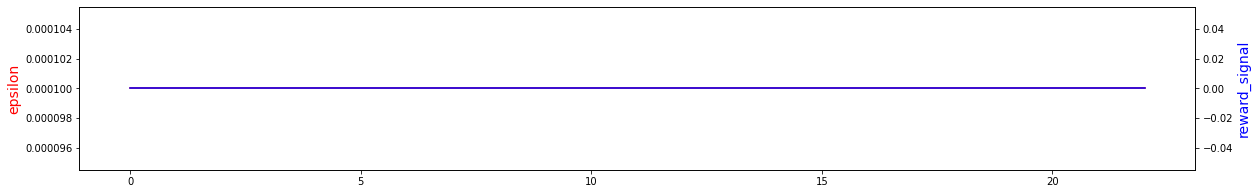

Bricks left to destroy  108.0
Lost one life after 46 timesteps
{'lives': 3, 'episode_frame_number': 219, 'frame_number': 219}


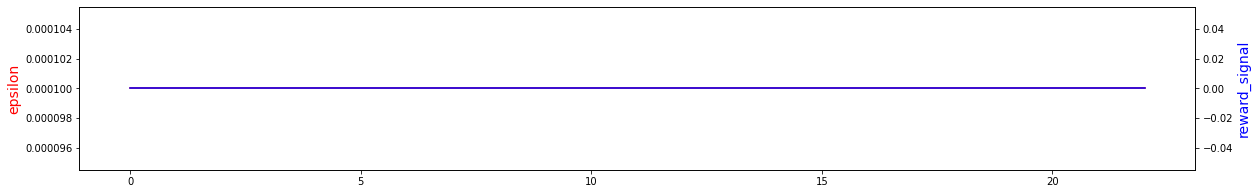

Bricks left to destroy  108.0
Lost one life after 69 timesteps
{'lives': 2, 'episode_frame_number': 323, 'frame_number': 323}


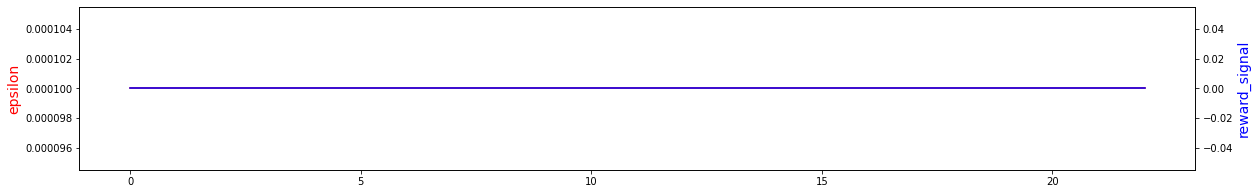

Bricks left to destroy  108.0
Lost one life after 92 timesteps
{'lives': 1, 'episode_frame_number': 427, 'frame_number': 427}


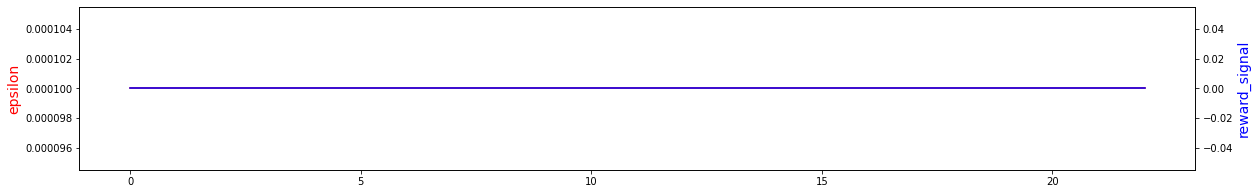

Bricks left to destroy  108.0


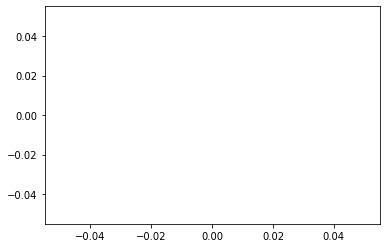

In [36]:
env = make_env()
#env = gym.wrappers.Monitor(env, "./vid1", force=True)

observation = env.reset()
info = 0
reward_window = []
reward_signal_history = []
epsilon_history = []

hits = []
bltd = 108 #total bricks to destroy

lives = 4

for i_episode in range(1):
    reward_window=[] 
    epsilon = 0  
    for t in range(4000):
        
        if epsilon > np.random.rand(1)[0]:
          action = np.random.choice(num_actions)
        else:
          state_tensor = tf.convert_to_tensor(observation)
          state_tensor = tf.expand_dims(state_tensor, 0)
          action_probs = model(state_tensor, training=False)
          action = tf.argmax(action_probs[0]).numpy()
        
        observation, reward, done, info = env.step(action)
        hits.append(reward)
        reward_window.append(reward)
        if len(reward_window) > 200:
          del reward_window[:1] 
        if len(reward_window) == 200 and np.sum(reward_window) == 0:
          epsilon = 0.01
        else:
          epsilon = 0.0001

        epsilon_history.append(epsilon)
        reward_signal_history.append(reward)

        
        if done:
            print("Lost one life after {} timesteps".format(t+1))
            print(info)
            # Plot epsilon and reward signal
            fig,ax=plt.subplots(figsize=(20,3))
            #plt.clf()
            ax.plot(epsilon_history, color="red")
            ax.set_ylabel("epsilon",color="red",fontsize=14)
            ax2=ax.twinx()
            ax2.plot(reward_signal_history,color="blue")
            ax2.set_ylabel("reward_signal",color="blue",fontsize=14)
            plt.show()

            epsilon_history = []
            reward_signal_history = []
            
            bltd = bltd-np.sum(hits)
            hits = []
            print("Bricks left to destroy ", bltd)
            #if info['ale.lives'] == 0:
            #  break
            lives -= 1
            if lives == 0:
              break

            env.reset()
env.close()
plt.plot(reward_signal_history)